In [ ]:
Why may we need multioutput regression?
There are two basic answers for that question. 
We need an elegant way to handle multiple models. In such scenario, we want e.g. produce the whole prediction interval at once or paralelly generate the forecasts for multiple product sales.
We want to benefit from the joint optimization. It may not be an obvious thing, but in some cases the mutual influence of the multiple target variables matters. 

Regarding the second point, we can specify several examples of specific situations, when we may need multi-target models:
Probabilistic modelling
Its a notable example In this approach, we need to generate as many outputs for each observation, as many parameter the chosen distribution has. For example, assuming the normal distribution, we treat each example as an individual re4alization of the gaussian random variable, so we need two parameters there mean and standard deviation for every single row in the input. Is rather multioutput, but not multitarget. 
Multi-step forecasting
In the field of time series forecasting, we often face a problem of generating forecasts for multiple timesteps ahead. Typically, it's handled by using a neural network or dealed by adapting a recurrent or direct forecasting approaches when using classical regression models.
Auxilliary targets
It not neceassary the case when we really predictions for all of those columns. Sometimes we can add it just as a auxilliary target. Is a known technique from the deep learning world and it works similarly to regularization. We simply adding some constraints to the model that way.

Of course, it's not a complete list. We can also need of combination of above, e.g. multi-step probabilstic forecasting with auxilliary targets. :) 
Does multi-output regression always equal multi-target regression?
Suprisingly, not necessary. Especially for probabilistic modelling/ prediction intervals you can get multiple predictions that describes exactly the same target variable. It's also disputable for multi-step time series modeling, because there you can also state that we're in fact still modelling the same target.

In [2]:
from scipy.io import arff
import numpy as np
import pandas as pd
import urllib.request

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from typing import List

np.random.seed(7)


def get_multitarget_data(name: str) -> pd.DataFrame:
    """Get multitaget regression dataset"""
    url = \
        f'https://raw.githubusercontent.com/tsoumakas/mulan/master/data/multi-target/{name}.arff'
    urllib.request.urlretrieve(url, f"{name}.arff")
    arff_data = arff.loadarff(f"{name}.arff")
    return pd.DataFrame(arff_data[0])


def as_data_frame(array: np.array, colnames: List[str]):
    df = pd.DataFrame(array)
    df.columns = colnames
    return df

In [3]:
ENB_TARGETS = ['Y1', 'Y2']
enb = get_multitarget_data('enb')

In [4]:
X, y = enb.iloc[:, :-2], enb.iloc[:, -2:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

y_train_, y_test_ = y_train.iloc[:, 0], y_test.iloc[:, 0]

In [5]:
enb

,Relative_compactness,X1,X3,X4,X5,X6,X7,X8,Y1,Y2
0,0.98,514.5,294.0,110.25,7.0,2.0,0.0,0.0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3.0,0.0,0.0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4.0,0.0,0.0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5.0,0.0,0.0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2.0,0.0,0.0,20.84,28.28
...,...,...,...,...,...,...,...,...,...,...
763,0.64,784.0,343.0,220.50,3.5,5.0,0.4,5.0,17.88,21.40
764,0.62,808.5,367.5,220.50,3.5,2.0,0.4,5.0,16.54,16.88
765,0.62,808.5,367.5,220.50,3.5,3.0,0.4,5.0,16.44,17.11
766,0.62,808.5,367.5,220.50,3.5,4.0,0.4,5.0,16.48,16.61


In [10]:
y_train.std()

Y1    10.094143
Y2     9.502553
dtype: float64

## Time series multistep

In [23]:
# !pip install sktime -U

In [104]:
from sktime.datasets import load_airline
from sktime.forecasting.compose import make_reduction, TransformedTargetForecaster
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.forecasting.trend import PolynomialTrendForecaster
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 8]

In [109]:
y = load_airline()
y_train, y_test = temporal_train_test_split(y, test_size=24)
dir_reg = TransformedTargetForecaster(
    [
        # ("deseasonalize", Deseasonalizer(model="multiplicative", sp=12)),
        ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
        ("forecast", make_reduction(XGBRegressor(), window_length=12, strategy="direct"),
        ),
    ]
)

dir_reg.fit(y=y_train, fh=list(range(1, 25)))

/home/krzysztof/.local/lib/python3.8/site-packages/sktime/forecasting/trend.py:23: FutureWarning: casting period[M] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x = x.astype("int64")
/home/krzysztof/.local/lib/python3.8/site-packages/sktime/forecasting/trend.py:23: FutureWarning: casting period[M] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x = x.astype("int64")


TransformedTargetForecaster(steps=[('detrend',
                                    Detrender(forecaster=PolynomialTrendForecaster())),
                                   ('forecast',
                                    DirectTabularRegressionForecaster(estimator=XGBRegressor(base_score=None,
                                                                                             booster=None,
                                                                                             callbacks=None,
                                                                                             colsample_bylevel=None,
                                                                                             colsample_bynode=None,
                                                                                             colsample_bytree=None,
                                                                                             early_stopping_rounds=None,
                                                                                             enable_categorical=False,
                                                                                             eval_metric=None,
                                                                                             feat...
                                                                                             grow_policy=None,
                                                                                             importance_type=None,
                                                                                             interaction_constraints=None,
                                                                                             learning_rate=None,
                                                                                             max_bin=None,
                                                                                             max_cat_threshold=None,
                                                                                             max_cat_to_onehot=None,
                                                                                             max_delta_step=None,
                                                                                             max_depth=None,
                                                                                             max_leaves=None,
                                                                                             min_child_weight=None,
                                                                                             missing=nan,
                                                                                             monotone_constraints=None,
                                                                                             n_estimators=100,
                                                                                             n_jobs=None,
                                                                                             num_parallel_tree=None,
                                                                                             predictor=None,
                                                                                             random_state=None, ...),
                                                                      window_length=12))])

/home/krzysztof/.local/lib/python3.8/site-packages/sktime/forecasting/trend.py:23: FutureWarning: casting period[M] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x = x.astype("int64")


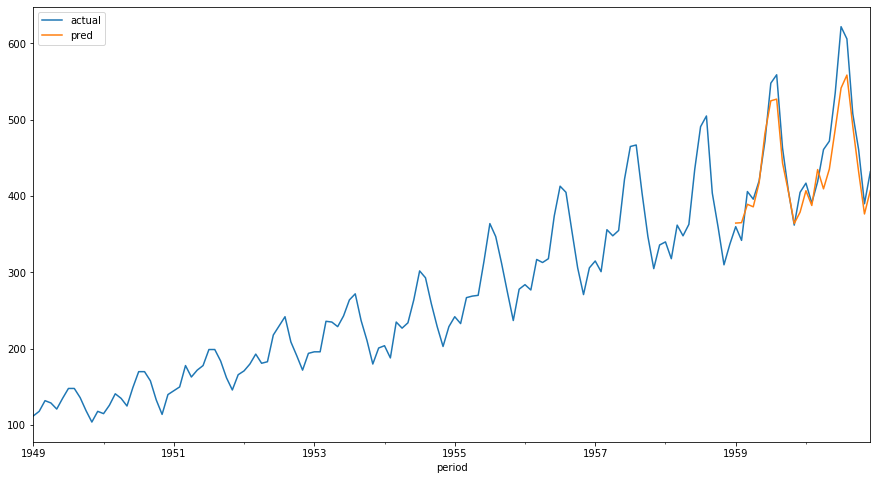

In [110]:
pred = pd.DataFrame(dir_reg.predict())
pred = pred.reset_index()
pred.columns = ['period', 'pred']

y_ = pd.DataFrame(y.reset_index())
y_.columns = ['period', 'actual']

results = y_.merge(pred, how='outer')
results.plot(x='period', y=['actual', 'pred'])
plt.savefig('img/ts.png')

## Multiouput regressor

In [54]:
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor

multi_reg = MultiOutputRegressor(
  estimator = XGBRegressor()
)

multi_reg.fit(X_train, y_train)
multi_reg_pred = multi_reg.predict(X_test)

mean_squared_error(y_test, multi_reg_pred)

0.3571980210054278

## Stacking

In [55]:
from sklearn.ensemble import StackingRegressor

In [66]:
stack_reg = StackingRegressor([('first', XGBRegressor(objective='quantile')), ('second', XGBRegressor())])
stack_reg.fit(X_train, y_train_)
stack_reg_pred = stack_reg.transform(X_test)

In [67]:
stack_reg_pred

array([[15.511324 , 15.511324 ],
       [34.783104 , 34.783104 ],
       [13.947851 , 13.947851 ],
       [15.245638 , 15.245638 ],
       [15.418469 , 15.418469 ],
       [11.556831 , 11.556831 ],
       [15.368175 , 15.368175 ],
       [21.439966 , 21.439966 ],
       [12.784396 , 12.784396 ],
       [29.85384  , 29.85384  ],
       [40.032055 , 40.032055 ],
       [25.864697 , 25.864697 ],
       [29.916    , 29.916    ],
       [32.3902   , 32.3902   ],
       [12.380065 , 12.380065 ],
       [16.409222 , 16.409222 ],
       [32.88576  , 32.88576  ],
       [12.619424 , 12.619424 ],
       [24.57272  , 24.57272  ],
       [17.00491  , 17.00491  ],
       [31.777853 , 31.777853 ],
       [23.535126 , 23.535126 ],
       [14.962844 , 14.962844 ],
       [ 6.7579064,  6.7579064],
       [26.539171 , 26.539171 ],
       [33.327812 , 33.327812 ],
       [40.675606 , 40.675606 ],
       [12.492324 , 12.492324 ],
       [28.923746 , 28.923746 ],
       [12.859074 , 12.859074 ],
       [11

## ML-Ensemble

In [83]:
from mlens.ensemble import SuperLearner
from lightgbm import LGBMRegressor

ensemble = SuperLearner()
ensemble.add([
    LGBMRegressor(objective='quantile', alpha=.1), 
    LGBMRegressor(objective='quantile', alpha=.5),
    LGBMRegressor(objective='quantile', alpha=.9)
])
ensemble.fit(X_train, y_train_)
multi_quantile_pred = ensemble.predict(X_test)
as_data_frame(multi_quantile_pred, ['q_10', 'q_50', 'q_90'])

,q_10,q_50,q_90
0,8.513427,18.487013,25.697308
1,34.737083,34.950523,36.076565
2,13.856725,14.225339,14.831547
3,15.178734,15.118778,15.410851
4,15.274887,15.285230,15.316581
...,...,...,...
149,11.388074,11.355670,12.460294
150,38.845280,40.151791,40.368675
151,32.023167,33.878841,33.604115
152,24.197632,25.229525,28.211617


## Decision tree

In [90]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(X_train, y_train)
tree_pred = tree_reg.predict(X_test)
as_data_frame(tree_pred, ENB_TARGETS)

,Y1,Y2
0,15.55,21.33
1,35.01,33.14
2,13.99,14.61
3,15.12,19.37
4,15.21,19.32
...,...,...
149,11.33,15.00
150,40.19,37.41
151,32.68,36.12
152,24.26,26.18


In [87]:
tree_pred

array([[15.55, 21.33],
       [35.01, 33.14],
       [13.99, 14.61],
       [15.12, 19.37],
       [15.21, 19.32],
       [11.69, 13.72],
       [15.34, 19.32],
       [20.71, 25.16],
       [12.74, 16.14],
       [29.34, 33.37],
       [40.11, 40.77],
       [25.17, 26.08],
       [29.54, 33.98],
       [31.84, 31.6 ],
       [12.41, 15.28],
       [16.95, 21.16],
       [33.08, 34.11],
       [12.41, 14.92],
       [24.63, 26.37],
       [17.14, 17.15],
       [32.75, 31.  ],
       [24.37, 25.11],
       [15.09, 18.36],
       [ 6.79, 12.05],
       [26.37, 27.03],
       [33.27, 33.88],
       [40.43, 39.48],
       [12.65, 15.85],
       [29.06, 33.84],
       [13.04, 14.34],
       [11.14, 14.28],
       [14.47, 17.23],
       [14.28, 15.87],
       [24.23, 25.02],
       [14.37, 16.61],
       [15.12, 19.26],
       [10.72, 14.2 ],
       [22.89, 28.88],
       [14.17, 16.94],
       [12.73, 13.89],
       [28.03, 34.45],
       [ 7.1 , 12.23],
       [32.74, 30.53],
       [14.

## XGBoost

In [93]:
xgb_reg = XGBRegressor()
xgb_reg.fit(X_train, y_train)
xgb_pred = xgb_reg.predict(X_test)
xgb_pred

array([[15.511324 , 21.402826 ],
       [34.783104 , 36.648224 ],
       [13.947851 , 14.98674  ],
       [15.245638 , 19.23377  ],
       [15.418469 , 19.088085 ],
       [11.556831 , 14.029214 ],
       [15.368175 , 19.501186 ],
       [21.439966 , 25.02736  ],
       [12.784396 , 15.846785 ],
       [29.85384  , 29.421429 ],
       [40.032055 , 40.17112  ],
       [25.864697 , 26.288603 ],
       [29.916    , 29.826935 ],
       [32.3902   , 31.748835 ],
       [12.380065 , 15.3679695],
       [16.409222 , 24.921953 ],
       [32.88576  , 33.620316 ],
       [12.619424 , 15.160378 ],
       [24.57272  , 25.606817 ],
       [17.00491  , 16.942495 ],
       [31.777853 , 35.065228 ],
       [23.535126 , 28.519701 ],
       [14.962844 , 17.824043 ],
       [ 6.7579064, 11.951133 ],
       [26.539171 , 26.29078  ],
       [33.327812 , 33.937263 ],
       [40.675606 , 39.596222 ],
       [12.492324 , 15.385861 ],
       [28.923746 , 30.027884 ],
       [12.859074 , 14.183141 ],
       [11

In [99]:
# xgb_quant_reg = XGBRegressor(objective='reg:quantileerror', alpha=[.1, .5, .9])
# xgb_quant_reg.fit(X_train, y_train_)
# xgb_quant_reg_pred = xgb_quant_reg.predict(X_test)

## CatBoost

In [103]:
from catboost import CatBoostRegressor

cb_reg = CatBoostRegressor(objective='MultiRMSE', verbose=0)
cb_reg.fit(X_train, y_train)
cb_reg_pred = cb_reg.predict(X_test)
cb_reg_pred

array([[15.90208835, 21.5394422 ],
       [34.7960029 , 38.13413696],
       [14.1427938 , 14.78940642],
       [15.19545131, 18.95886058],
       [15.27834957, 19.11607436],
       [11.41802172, 14.32192564],
       [15.32642669, 19.36121486],
       [21.17234156, 24.88705532],
       [12.84669   , 15.83145746],
       [29.84917125, 29.59294499],
       [39.93581631, 39.93932422],
       [26.15978469, 25.69214293],
       [29.97704558, 29.78323929],
       [32.0956379 , 32.38898985],
       [12.39643721, 15.51000768],
       [17.14814222, 25.5616031 ],
       [32.86548056, 34.31637819],
       [12.41330194, 15.10958681],
       [23.86424023, 25.86703661],
       [17.32838014, 17.1167848 ],
       [31.79746036, 34.73586001],
       [23.21733895, 28.7368369 ],
       [14.69430794, 17.65226295],
       [ 6.70506029, 11.87274073],
       [26.48412527, 26.74831613],
       [33.11551571, 34.53631388],
       [40.08801658, 39.79316909],
       [12.51655538, 15.62755535],
       [28.86206007,

## NGBoost

In [106]:
from ngboost import NGBRegressor
from ngboost.distns import MultivariateNormal

dist = MultivariateNormal(2)

ngb = NGBRegressor(Dist=dist).fit(X_train, y_train)

[iter 0] loss=5.8935 val_loss=0.0000 scale=1.0000 norm=12.9220
[iter 100] loss=4.8549 val_loss=0.0000 scale=1.0000 norm=5.2986
[iter 200] loss=4.1402 val_loss=0.0000 scale=1.0000 norm=2.9352
[iter 300] loss=3.6096 val_loss=0.0000 scale=0.5000 norm=1.1249
[iter 400] loss=3.1095 val_loss=0.0000 scale=0.5000 norm=0.9669


In [107]:
ngb.predict(X_test)

array([[17.53539431, 23.06607019],
       [34.44305144, 35.469184  ],
       [15.12398566, 15.77859821],
       [14.69571966, 18.99568066],
       [14.69571966, 18.99568066],
       [11.85127023, 14.73663839],
       [14.69571966, 18.99568066],
       [21.56875257, 27.07637058],
       [13.07945143, 16.01602882],
       [28.88896739, 31.50898889],
       [39.3869988 , 39.1005649 ],
       [26.4753206 , 28.96241958],
       [28.88896739, 31.50898889],
       [31.74344568, 33.14229817],
       [12.49093061, 15.56540214],
       [18.64360644, 23.64696344],
       [33.34403043, 34.26792225],
       [12.49093061, 15.25478065],
       [25.22604621, 26.75255813],
       [17.05023117, 17.46205169],
       [31.74344568, 33.14229817],
       [24.39869458, 27.11874931],
       [14.74382676, 17.71704116],
       [ 7.01230085, 12.13185305],
       [26.45659573, 28.91019103],
       [33.34403043, 34.26792225],
       [39.3869988 , 39.23060387],
       [12.49093061, 15.37946848],
       [29.29339903,

## TF Decision Forests

In [109]:
# !pip install tensorflow_decision_forests --upgrade

In [7]:
import tensorflow_decision_forests as tfdf
import pandas as pd

# Load a dataset in a Pandas dataframe.

train_df = enb.loc[X_train.index]
test_df = enb.loc[X_test.index]

mulitask = [tfdf.keras.MultiTaskItem(label=t, task=tfdf.keras.Task.REGRESSION)
           for t in ENB_TARGETS]

# Convert the dataset into a TensorFlow dataset.
#train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_df, label="Y1", task=tfdf.keras.Task.REGRESSION)
#test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_df, label="Y1", task=tfdf.keras.Task.REGRESSION)

# Train a GBM model
model = tfdf.keras.GradientBoostedTreesModel(
    multitask = mulitask,
    loss = 'SQUARED_ERROR'
)

Use /tmp/tmpvyj_3y86 as temporary training directory


2023-04-02 23:45:35.988684: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-02 23:45:36.092689: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-02 23:45:36.093434: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [12]:
y_dict = {
    'Y1':y_train.iloc[:, 0].values,
    'Y2':y_train.iloc[:, 1].values
}
model.fit(X_train.values, y_dict)

Reading training dataset...
Training dataset read in 0:00:02.049447. Found 614 examples.
Training model...
Model trained in 0:00:00.796633
Compiling model...


[INFO 23-04-02 23:48:40.7257 CEST kernel.cc:1242] Loading model from path /tmp/tmpvyj_3y86/model/ with prefix d8fd64b175dc4dfe_0
[INFO 23-04-02 23:48:40.7934 CEST abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-04-02 23:48:40.7934 CEST kernel.cc:1074] Use fast generic engine
[INFO 23-04-02 23:48:40.7997 CEST kernel.cc:1242] Loading model from path /tmp/tmpvyj_3y86/model/ with prefix d8fd64b175dc4dfe_1
[INFO 23-04-02 23:48:40.8396 CEST kernel.cc:1074] Use fast generic engine


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.


In [13]:
pred = model.predict(X_test.values)

5/5 [==============================] - 0s 2ms/step


In [14]:
pred

{'Y1': array([[39.75277  ],
        [12.769988 ],
        [12.793824 ],
        [24.072113 ],
        [14.193558 ],
        [24.283962 ],
        [14.528009 ],
        [23.789822 ],
        [13.976234 ],
        [39.579777 ],
        [26.487211 ],
        [29.027227 ],
        [40.718918 ],
        [15.303    ],
        [35.86167  ],
        [17.117344 ],
        [13.743711 ],
        [26.015425 ],
        [18.739128 ],
        [12.944093 ],
        [14.666053 ],
        [14.16421  ],
        [29.870487 ],
        [18.131086 ],
        [17.276575 ],
        [12.986608 ],
        [11.551844 ],
        [14.761011 ],
        [29.441053 ],
        [15.272564 ],
        [ 6.912014 ],
        [14.413601 ],
        [14.487042 ],
        [39.750786 ],
        [12.737562 ],
        [32.42993  ],
        [16.542551 ],
        [26.503447 ],
        [24.247906 ],
        [12.474431 ],
        [16.457832 ],
        [40.388184 ],
        [15.258104 ],
        [14.195854 ],
        [16.916466 ],
    

## GBM from scratch

In [ ]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler

# Kiepska implementacja
# https://towardsdatascience.com/gradient-boosting-in-python-from-scratch-788d1cf1ca7 

# XGBoost
# https://towardsdatascience.com/de-mystifying-xgboost-part-i-f37c5e64ec8e
# StatQuest
# https://medium.com/@frauke.albrecht/loss-functions-in-xgboost-c89885b57346

# https://en.wikipedia.org/wiki/Gradient_boosting#:~:text=Gradient%20boosting%20is%20a%20machine%20learning%20technique%20used,weak%20prediction%20models,%20which%20are%20typically%20decision%20trees.
# https://github.com/scikit-learn/scikit-learn/blob/9aaed498795f68e5956ea762fef9c440ca9eb239/sklearn/tree/_criterion.pyx#L787
# https://stats.stackexchange.com/questions/111467/is-it-necessary-to-scale-the-target-value-in-addition-to-scaling-features-for-re

# Skalowanie targetów może być konieczne w tym przypadku!

# Why it doesn't use 1/N?
def l2_loss(y_true, y_pred):
    # Gdzie znika tenb minus? Czy to jest antygradient?
    grad = 2 * (y_true - y_pred)
    # hess = 2
    return grad


class MultiOutputGBM:
    
    def __init__(self, n_estimators: int = 100, 
                 learning_rate: float = .1):
        # self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.estimators_ = [
            DecisionTreeRegressor() for _ in range(n_estimators)
        ]
    
    def fit(self, X, y):
        
        # Calculate mean
        self.mean = pred = np.mean(y)
        
        for est in self.estimators_:
            
            # 1. Deifniujemy kierunek (pseudo-residuals)
            # 2. Definiujemy długość kroku używając "linea search"
            
            # Calculating pseudo-residuals
            y_ = l2_loss(y, pred)
            
            # Fitting the model, returning predictions
            est.fit(X, y_)
            pred_ = est.predict(X)
            
            # Line search
            # https://stackoverflow.com/questions/41228470/how-does-scikitlearn-implement-line-search
            # https://medium.com/analytics-vidhya/what-makes-xgboost-so-extreme-e1544a4433bb
            
    
    def predict(self, X):
        preds = []
        for est in self.estimators_:
            pred.append(est.predict(X))
        return pd.DataFrame(preds).sum(axis=1)